In [1]:

! pip install statsmodels


In [2]:
! pip install pandas_datareader


In [3]:
! pip install datetime


In [4]:
! pip install  yfinance

In [5]:
! pip install PyPortfolioOpt

 Trading Strategy

1. Download/Load SP500 stocks prices data.

In [6]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2023-09-27'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  503 of 503 completed

4 Failed downloads:
['GEV', 'VLTO', 'SW', 'SOLV']: YFChartError("%ticker%: Data doesn't exist for startDate = 1443499200, endDate = 1695787200")


Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.425238   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361622   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.651133   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.004150   52.790001   54.189999   51.880001   53.099998   
           ABT      33.302021   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.736298   89.519997   90.849998   89.500000   90.379997   
           YUM     122.211014  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.534821  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.131134  176.869995  178.449997  176.270004  176.580002   

Price                   volume  
date       ticker               
2015-09-29 A         2252400.0  
           AAL       7478800.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
...                        ...  
2023-09-26 XYL       1322400.0  
           YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZTS       1463200.0  

[985955 rows x 6 columns]

2. Calculate features and technical indicators for each stock.
Garman-Klass Volatility
RSI
Bollinger Bands
ATR
MACD
Dollar 
Volume
 
 


In [7]:
pip install pandas-ta

Note: you may need to restart the kernel to use updated packages.


In [8]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.425238   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361622   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.651133   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.004150   52.790001   54.189999   51.880001   53.099998   
           ABT      33.302021   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.736298   89.519997   90.849998   89.500000   90.379997   
           YUM     122.211014  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.534821  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.131134  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.001082        NaN       NaN   
           AAL       7478800.0         -0.000443        NaN       NaN   
           AAPL    293461600.0         -0.005712        NaN       NaN   
           ABBV     12842800.0         -0.057368        NaN       NaN   
           ABT      12287500.0         -0.010064        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYL       1322400.0         -0.000018  26.146739  4.485761   
           YUM       1500600.0         -0.000051  36.057161  4.811707   
           ZBH       3610500.0          0.000022  31.893227  4.745884   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZTS       1463200.0          0.000049  42.623473  5.153746   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-09-29 A            NaN       NaN       NaN       NaN      70.782205  
           AAL          NaN       NaN       NaN       NaN     279.420098  
           AAPL         NaN       NaN       NaN       NaN    7234.160810  
           ABBV         NaN       NaN       NaN       NaN     462.394103  
           ABT          NaN       NaN       NaN       NaN     409.198583  
...                     ...       ...       ...       ...            ...  
2023-09-26 XYL     4.567684  4.649607  0.033800 -2.159189     117.344880  
           YUM     4.841672  4.871637  0.142547 -1.363695     183.389847  
           ZBH     4.785551  4.825217 -0.381708 -0.881067     402.696470  
           ZBRA    5.539167  5.677342 -0.057389 -1.600791      79.595386  
           ZTS     5.212559  5.271371  0.651515 -1.188278     256.251875  

[985955 rows x 14 columns]

3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.
To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [9]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2015-11-30 A          135.740917   38.950897         -0.002098  73.421597   
           AAL        287.915803   39.429928         -0.000966  40.718994   
           AAPL      4023.983938   26.854137         -0.003307  55.537377   
           ABBV       334.491216   40.025848         -0.062372  49.376893   
           ABT        210.542064   38.091480         -0.011927  56.962577   
...                          ...         ...               ...        ...   
2023-09-30 OTIS       154.361757   78.356499         -0.000097  33.116206   
           ABNB      1633.500725  132.279999          0.000213  44.494127   
           CEG        196.670368  107.862022          0.000131  55.245465   
           GEHC       212.197214   66.105721          0.000185  40.922328   
           KVUE       670.804280   20.006195         -0.000159  35.706336   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2015-11-30 A       3.544191  3.616636  3.689080 -1.033887  0.567157  
           AAL     3.672028  3.749832  3.827636  0.190822 -0.418773  
           AAPL    3.281679  3.324991  3.368302 -0.967900 -0.142790  
           ABBV    3.717771  3.766009  3.814247 -0.526809  0.145677  
           ABT     3.650901  3.672752  3.694603 -1.064842  0.335557  
...                     ...       ...       ...       ...       ...  
2023-09-30 OTIS    4.370137  4.415425  4.460712 -1.028320 -1.534536  
           ABNB    4.857047  4.940924  5.024801 -1.006939 -0.037854  
           CEG     4.652147  4.692320  4.732493 -0.436215  0.366876  
           GEHC    4.155071  4.212607  4.270142 -0.893478 -1.116463  
           KVUE    3.014275  3.089221  3.164168 -0.899746 -1.435620  

[46553 rows x 9 columns]

Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [10]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data


adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2016-10-31 AAL      39.134327         -0.000176  62.203544  3.604673   
           AAPL     26.212479         -0.002468  49.891136  3.294237   
           ABBV     39.878784         -0.049190  27.477722  3.744517   
           ABT      34.112473         -0.008074  38.008802  3.549492   
           ACN     103.117393         -0.005023  53.823641  4.633009   
...                       ...               ...        ...       ...   
2023-09-30 XOM     113.372101         -0.000065  59.440190  4.687091   
           MRNA     98.120003          0.000146  38.747314  4.582514   
           UBER     44.270000          0.000441  45.005268  3.806654   
           CRWD    160.479996          0.000144  51.534803  5.026187   
           ABNB    132.279999          0.000213  44.494127  4.857047   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2016-10-31 AAL     3.655493  3.706314  0.402199  1.131595  
           AAPL    3.323117  3.351997 -1.038688 -0.195978  
           ABBV    3.798670  3.852823 -0.893132 -0.760593  
           ABT     3.599959  3.650426 -1.035224 -0.650889  
           ACN     4.644646  4.656283 -0.996806 -0.135456  
...                     ...       ...       ...       ...  
2023-09-30 XOM     4.727187  4.767283  0.601335  1.400623  
           MRNA    4.685332  4.788149 -0.529511 -0.376899  
           UBER    3.862227  3.917801 -0.746098 -0.133973  
           CRWD    5.103696  5.181204 -0.744862  0.245950  
           ABNB    4.940924  5.024801 -1.006939 -0.037854  

[12516 rows x 8 columns]

4. Calculate Monthly Returns for different time horizons as features.
To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [11]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-10-31 AAL      45.534168         -0.000363  41.051791  3.849110   
           AAPL     39.713898         -0.001055  69.196718  3.594730   
           ABBV     66.876801         -0.036142  55.247863  4.187696   
           ABT      48.237461         -0.005677  53.844867  3.887384   
           ACN     128.834717         -0.004274  69.365325  4.798335   
...                       ...               ...        ...       ...   
2023-09-30 XOM     113.372101         -0.000065  59.440190  4.687091   
           MRNA     98.120003          0.000146  38.747314  4.582514   
           UBER     44.270000          0.000441  45.005268  3.806654   
           CRWD    160.479996          0.000144  51.534803  5.026187   
           ABNB    132.279999          0.000213  44.494127  4.857047   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2017-10-31 AAL     3.921750  3.994389  1.011062 -0.018697  -0.014108   
           AAPL    3.641603  3.688475 -0.906642 -0.039276   0.096808   
           ABBV    4.234050  4.280405  0.375557  0.473813   0.022728   
           ABT     3.910952  3.934519 -1.040044  0.276133   0.021276   
           ACN     4.838013  4.877691 -0.986514  0.352343   0.064180   
...                     ...       ...       ...       ...        ...   
2023-09-30 XOM     4.727187  4.767283  0.601335  1.400623   0.046947   
           MRNA    4.685332  4.788149 -0.529511 -0.376899  -0.132219   
           UBER    3.862227  3.917801 -0.746098 -0.133973  -0.062672   
           CRWD    5.103696  5.181204 -0.744862  0.245950  -0.015641   
           ABNB    4.940924  5.024801 -1.006939 -0.037854   0.005549   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-10-31 AAL      0.022981  -0.023860   0.016495   0.007008    0.012702  
           AAPL     0.015249   0.044955   0.028875   0.038941    0.035228  
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026  
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294  
           ACN      0.048455   0.037203   0.028692   0.027398    0.018728  
...                      ...        ...        ...        ...         ...  
2023-09-30 XOM      0.046139   0.030496   0.012838   0.008747    0.027037  
           MRNA    -0.086803  -0.068763  -0.071952  -0.064976   -0.015431  
           UBER    -0.053920   0.008422   0.057244   0.066838    0.043691  
           CRWD    -0.003656   0.029981   0.026391   0.047942   -0.002216  
           ABNB    -0.067704   0.010603   0.010289   0.049124    0.019401  

[10343 rows x 14 columns]

5. Download Fama-French Factors and Calculate Rolling Factor Betas.
We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [12]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096808
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021276
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0181  0.0151  0.0187 -0.0082   0.009617
           VZ     -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.056890
           WFC    -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.015500
           WMT    -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.000676
           XOM    -0.0524 -0.0181  0.0151  0.0187 -0.0082   0.046947

[10343 rows x 6 columns]

Filter out stocks with less than 10 months of data.

In [13]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096808
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021276
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0181  0.0151  0.0187 -0.0082   0.009617
           VZ     -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.056890
           WFC    -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.015500
           WMT    -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.000676
           XOM    -0.0524 -0.0181  0.0151  0.0187 -0.0082   0.046947

[10313 rows x 6 columns]

Calculate Rolling Factor Betas.

In [14]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VRTX    0.456835 -0.444629 -0.314191 -0.077989  0.802008
           VZ      0.332723 -0.166037  0.265927  0.311103  0.108626
           WFC     1.120621  0.297485  2.062606 -0.441339 -1.519517
           WMT     0.700773 -0.313571 -0.413681 -0.141574  0.508839
           XOM     0.983098 -1.094427  1.756406 -0.640016 -0.368887

[10313 rows x 5 columns]

Join the rolling factors data to the main features dataframe.

In [15]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10092 entries, (Timestamp('2017-10-31 00:00:00'), 'AAL') to (Timestamp('2023-09-30 00:00:00'), 'CRWD')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10092 non-null  float64
 1   rsi               10092 non-null  float64
 2   bb_low            10092 non-null  float64
 3   bb_mid            10092 non-null  float64
 4   bb_high           10092 non-null  float64
 5   atr               10092 non-null  float64
 6   macd              10092 non-null  float64
 7   return_1m         10092 non-null  float64
 8   return_2m         10092 non-null  float64
 9   return_3m         10092 non-null  float64
 10  return_6m         10092 non-null  float64
 11  return_9m         10092 non-null  float64
 12  return_12m        10092 non-null  float64
 13  Mkt-RF            10092 non-null  float64
 14  SMB               10092 non-null  float64
 15  HML       

At this point we have to decide on what ML model and approach to use for predictions etc.
6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
K-Means Clustering
You may want to initialize predefined centroids for each cluster based on your research.

For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

Then we will pre-define our centroids for each cluster.

In [16]:
from sklearn.cluster import KMeans

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init='random').fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2017-10-31 AAL            -0.000363  41.051791  3.849110  3.921750  3.994389   
           AAPL           -0.001055  69.196718  3.594730  3.641603  3.688475   
           ABBV           -0.036142  55.247863  4.187696  4.234050  4.280405   
           ABT            -0.005677  53.844867  3.887384  3.910952  3.934519   
           ACN            -0.004274  69.365325  4.798335  4.838013  4.877691   
...                             ...        ...       ...       ...       ...   
2023-09-30 WMT            -0.000041  54.722532  3.984976  4.002446  4.019915   
           XOM            -0.000065  59.440190  4.687091  4.727187  4.767283   
           MRNA            0.000146  38.747314  4.582514  4.685332  4.788149   
           UBER            0.000441  45.005268  3.806654  3.862227  3.917801   
           CRWD            0.000144  51.534803  5.026187  5.103696  5.181204   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2017-10-31 AAL     1.011062 -0.018697  -0.014108   0.022981  -0.023860   
           AAPL   -0.906642 -0.039276   0.096808   0.015249   0.044955   
           ABBV    0.375557  0.473813   0.022728   0.098590   0.091379   
           ABT    -1.040044  0.276133   0.021276   0.034308   0.034801   
           ACN    -0.986514  0.352343   0.064180   0.048455   0.037203   
...                     ...       ...        ...        ...        ...   
2023-09-30 WMT    -0.196381  0.399458  -0.000676   0.010014   0.012354   
           XOM     0.601335  1.400623   0.046947   0.046139   0.030496   
           MRNA   -0.529511 -0.376899  -0.132219  -0.086803  -0.068763   
           UBER   -0.746098 -0.133973  -0.062672  -0.053920   0.008422   
           CRWD   -0.744862  0.245950  -0.015641  -0.003656   0.029981   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-10-31 AAL      0.016495   0.007008    0.012702  1.265330  1.314923   
           AAPL     0.028875   0.038941    0.035228  1.276026 -0.271593   
           ABBV     0.056495   0.047273    0.044026  0.494533  0.362681   
           ABT      0.038672   0.031320    0.029294  0.828390 -0.199397   
           ACN      0.028692   0.027398    0.018728  1.199020 -0.166370   
...                      ...        ...         ...       ...       ...   
2023-09-30 WMT      0.017574   0.016553    0.020256  0.740243 -0.259781   
           XOM      0.012838   0.008747    0.027037  1.005608 -1.051739   
           MRNA    -0.071952  -0.064976   -0.015431  1.154879  0.766422   
           UBER     0.057244   0.066838    0.043691  1.078514  1.163168   
           CRWD     0.026391   0.047942   -0.002216  0.594732 -0.940715   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-10-31 AAL     0.600746  0.459424  0.563337        1  
           AAPL   -0.591213  0.647542  0.458386        2  
           ABBV   -0.032806  0.242182  0.164051        0  
           ABT    -0.529386  0.251775  0.970503        0  
           ACN    -0.328321  0.268152  0.168631        2  
...                     ...       ...       ...      ...  
2023-09-30 WMT    -0.522484 -0.125198  0.642485        3  
           XOM     1.707636 -0.674966 -0.284575        3  
           MRNA   -1.163095  0.593370  0.989911        0  
           UBER   -0.257055 -1.482917 -0.449948        1  
           CRWD   -0.678313 -2.449974 -0.814519        3  

[10092 rows x 19 columns]

In [17]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

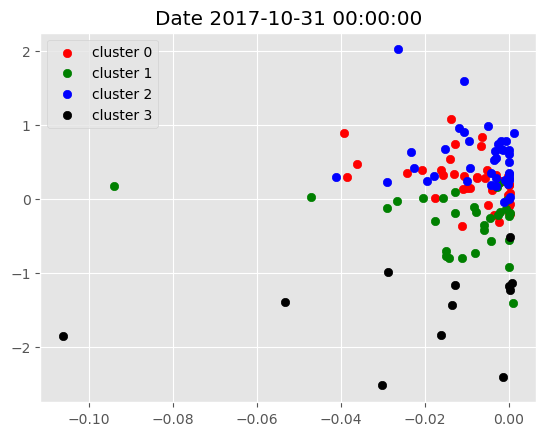

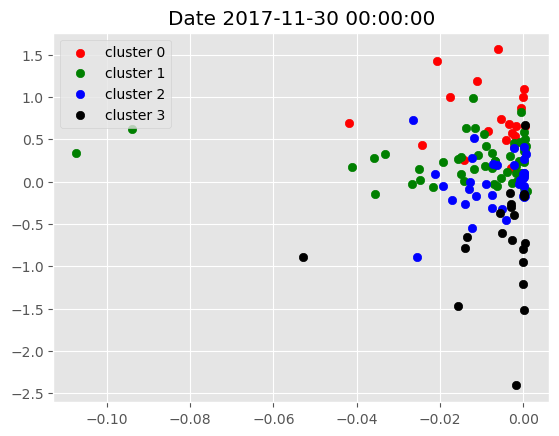

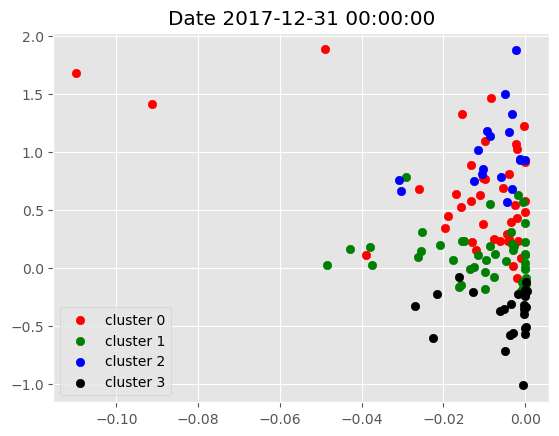

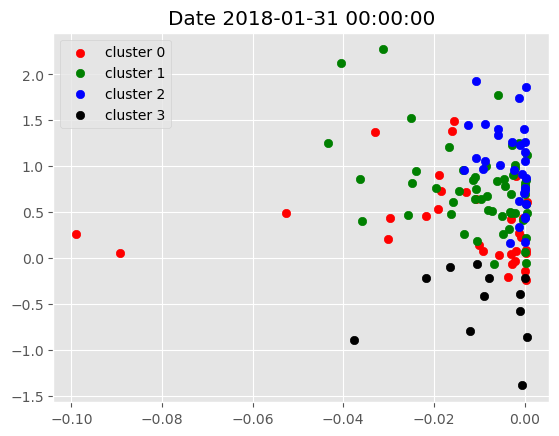

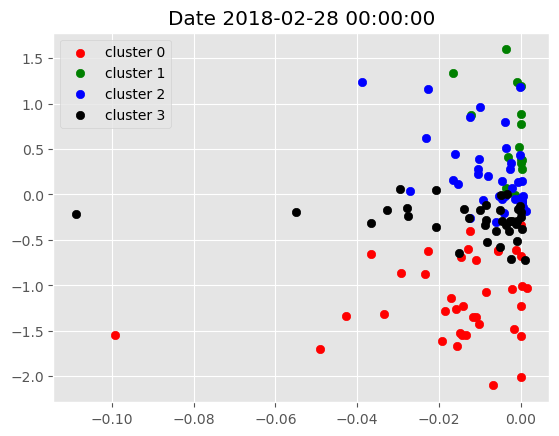

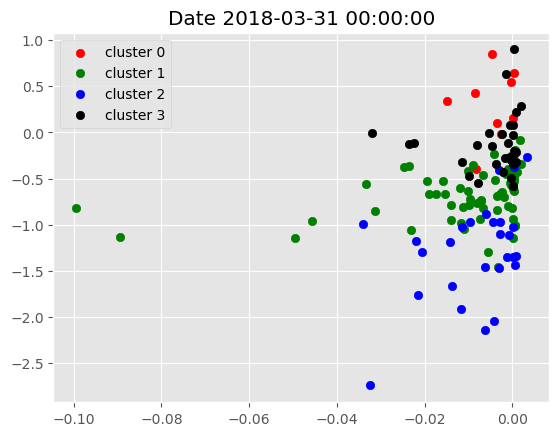

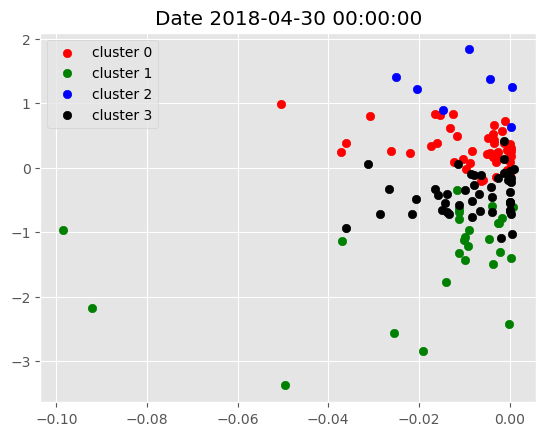

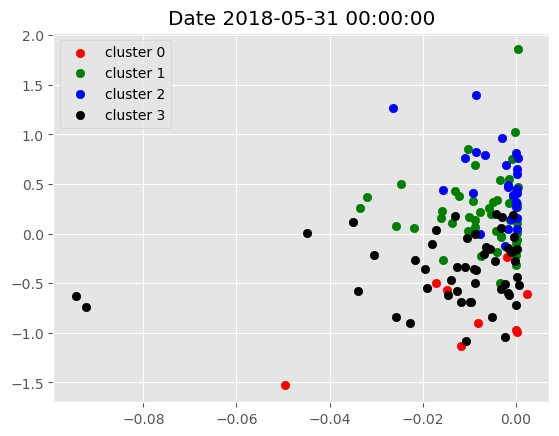

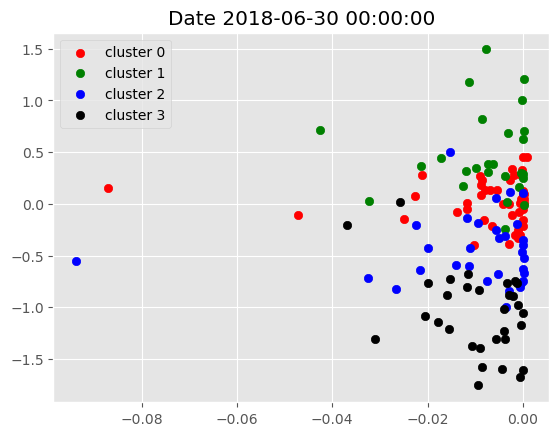

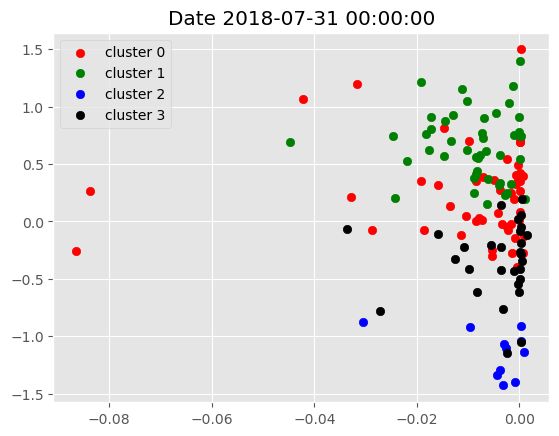

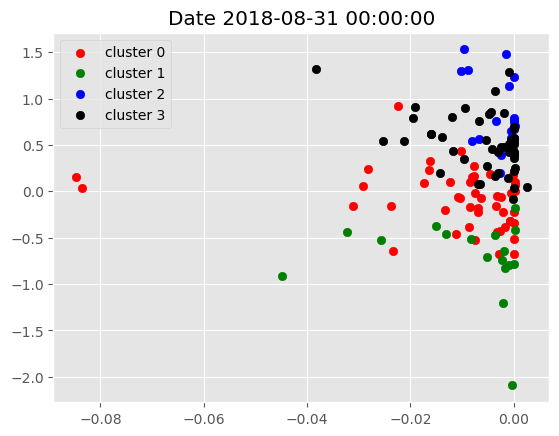

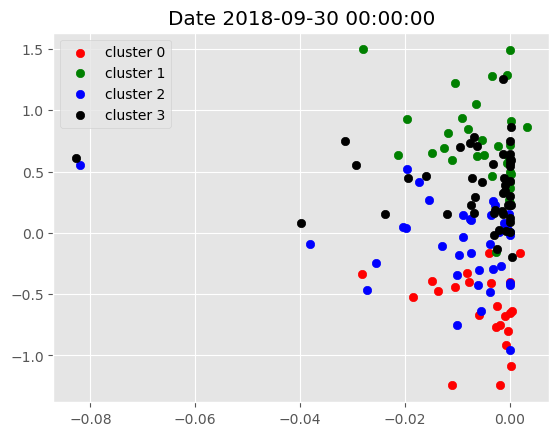

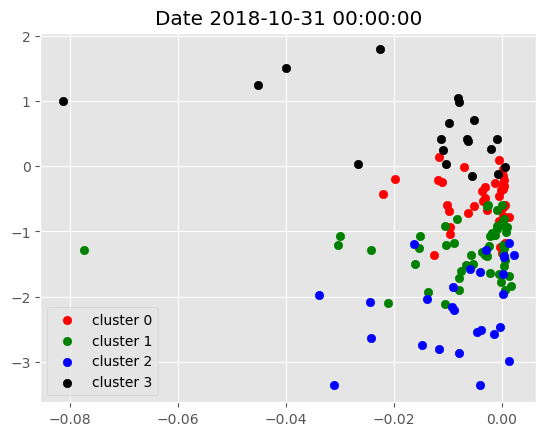

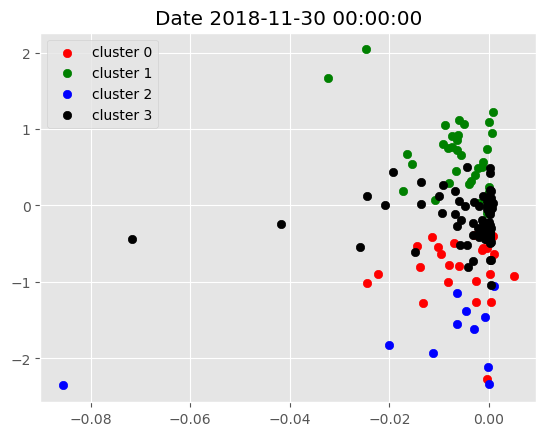

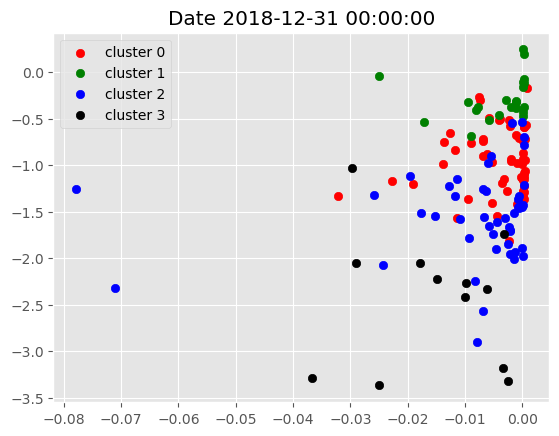

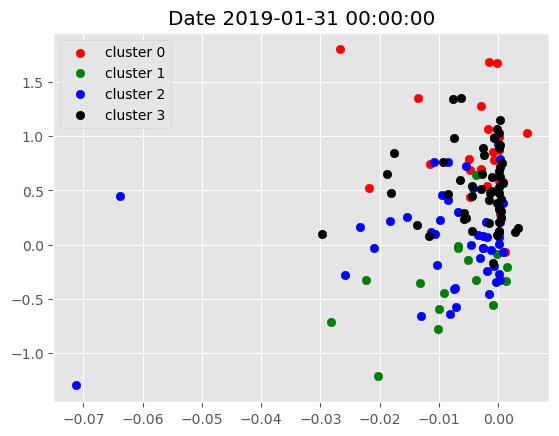

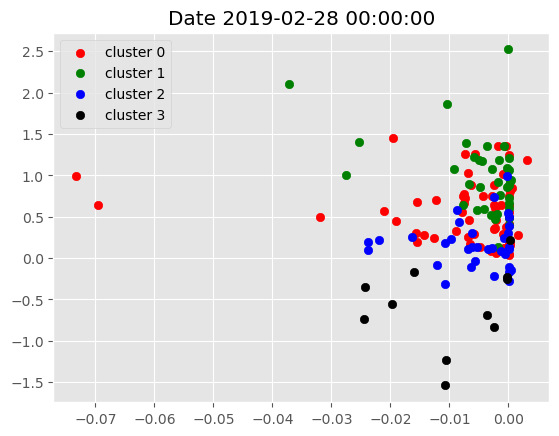

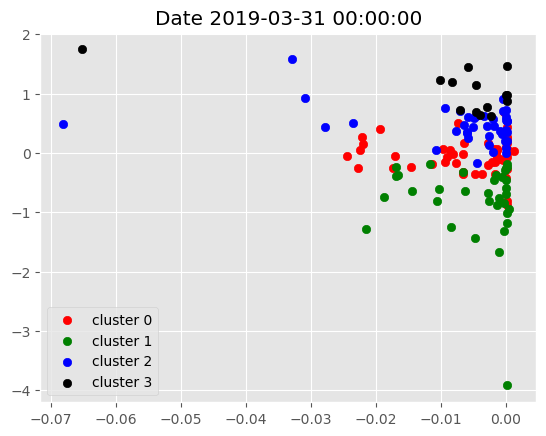

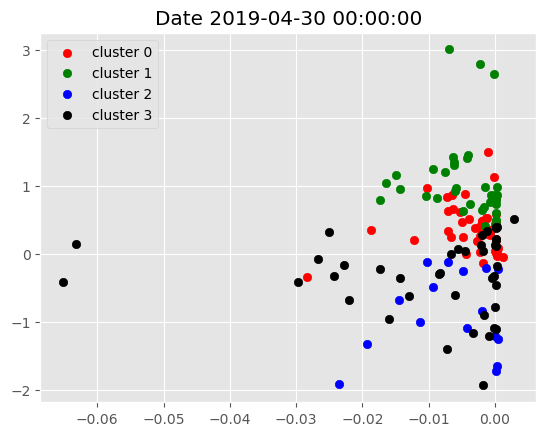

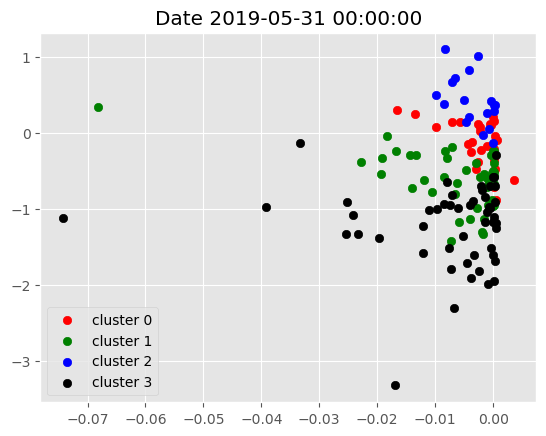

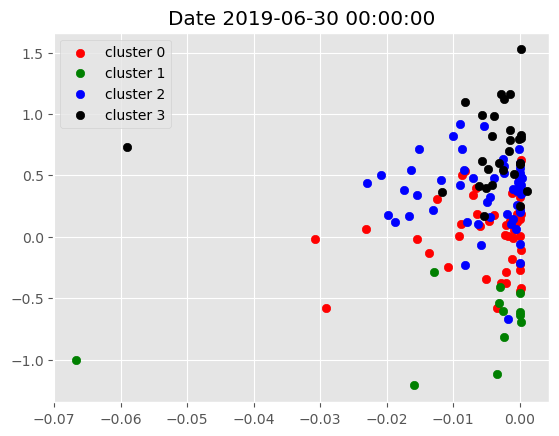

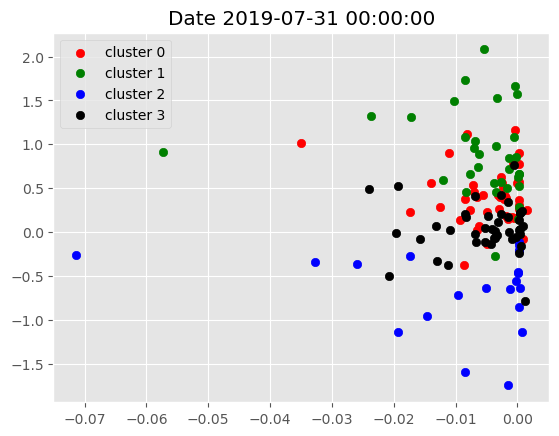

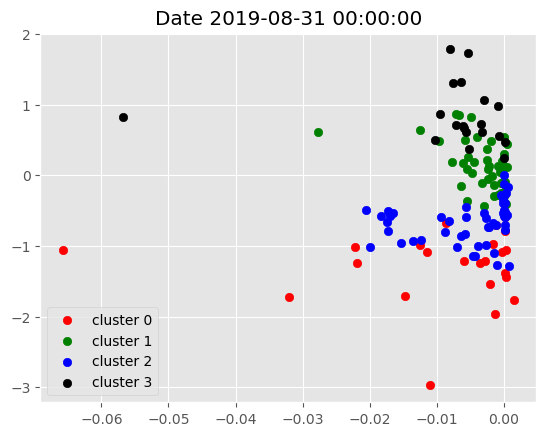

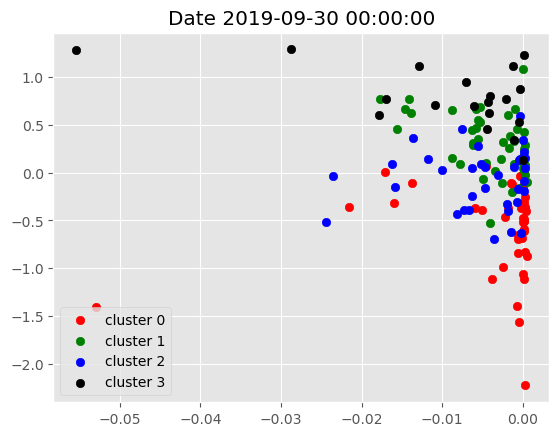

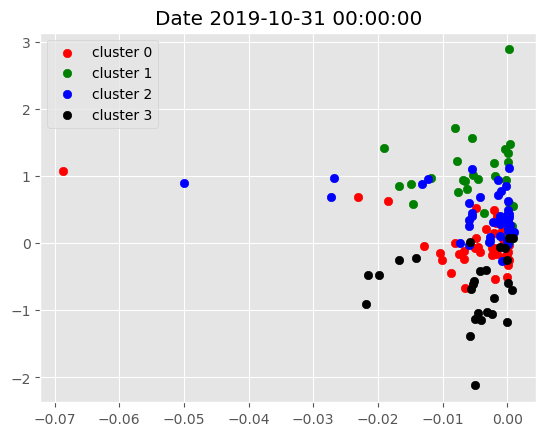

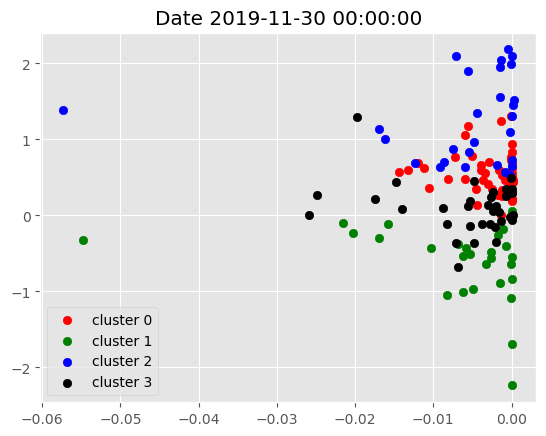

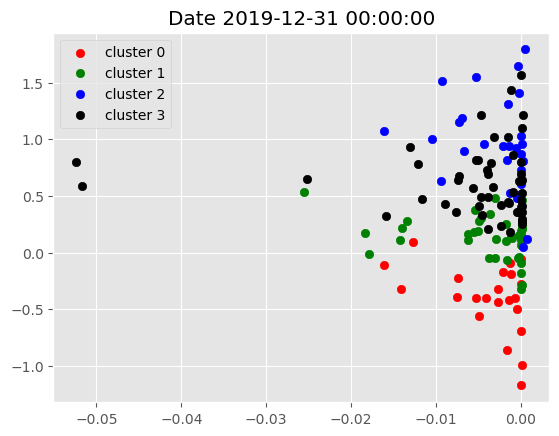

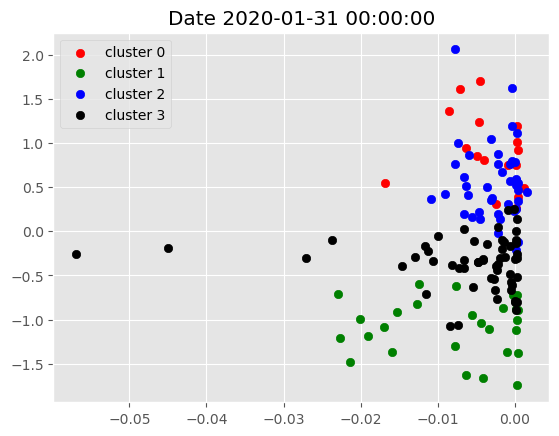

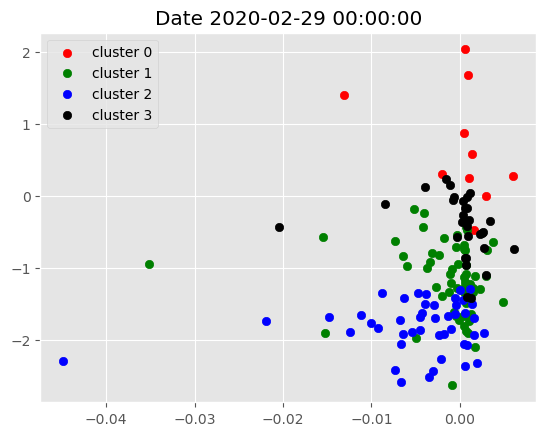

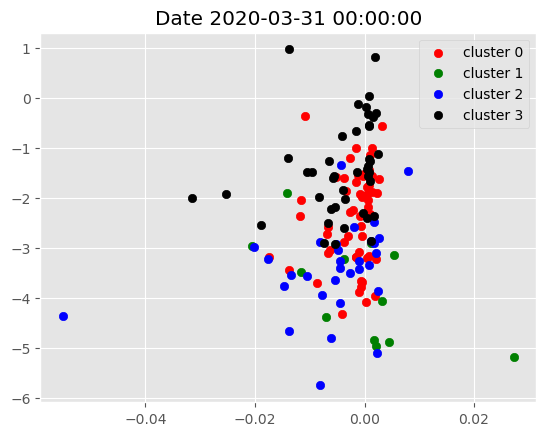

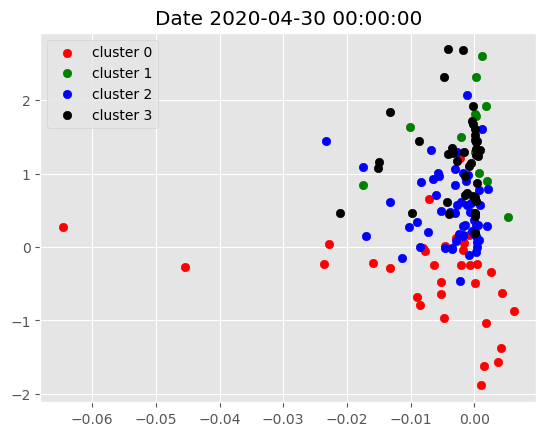

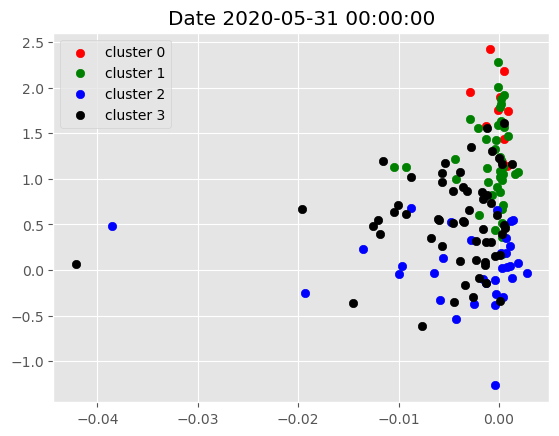

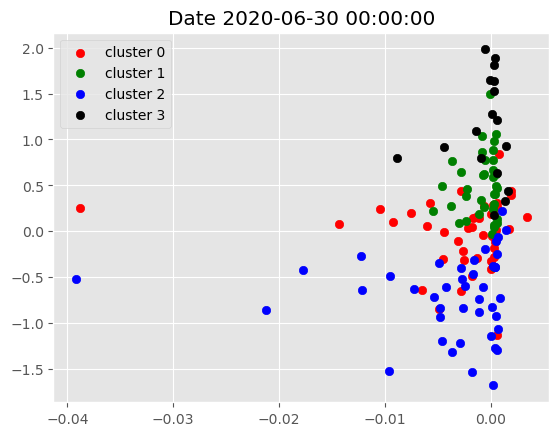

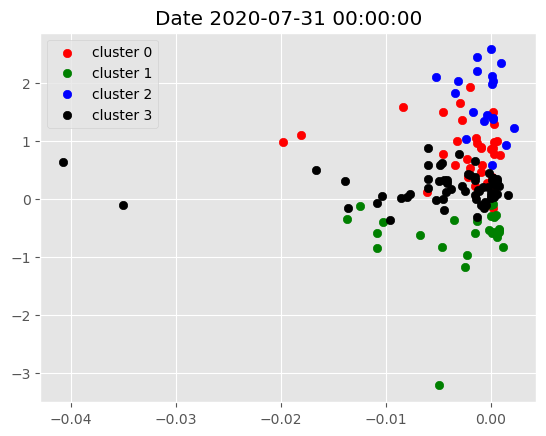

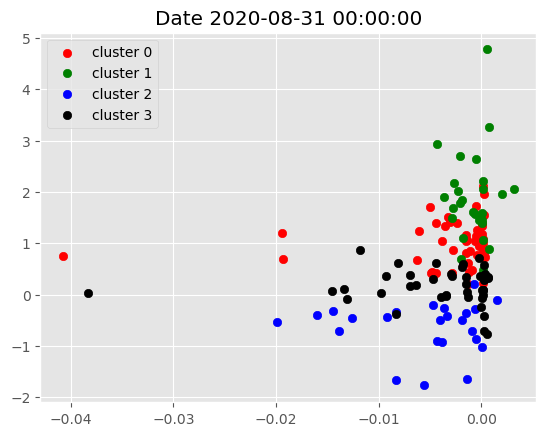

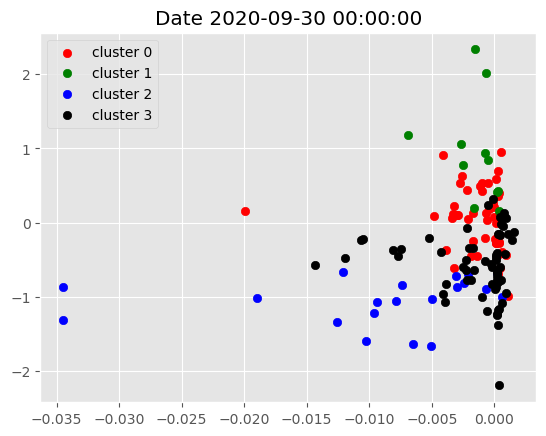

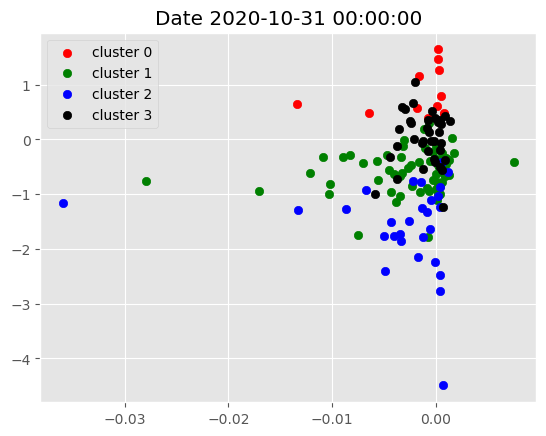

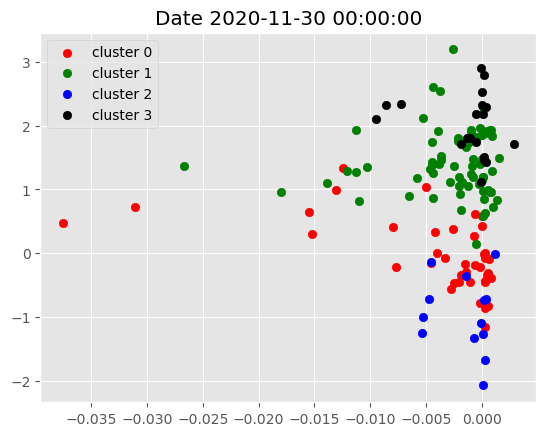

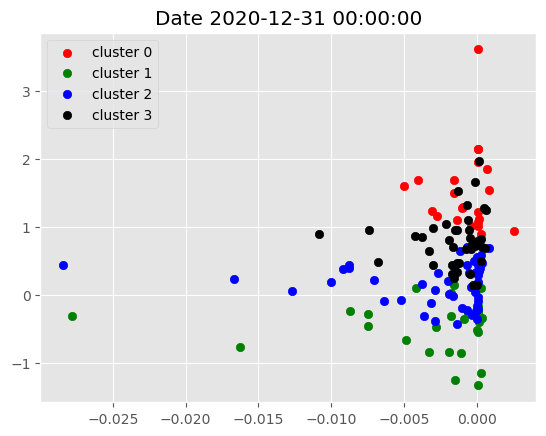

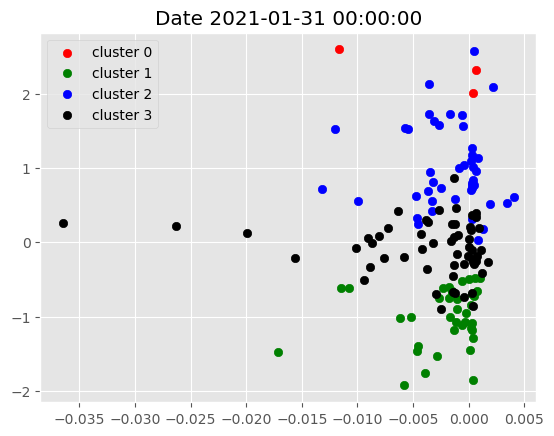

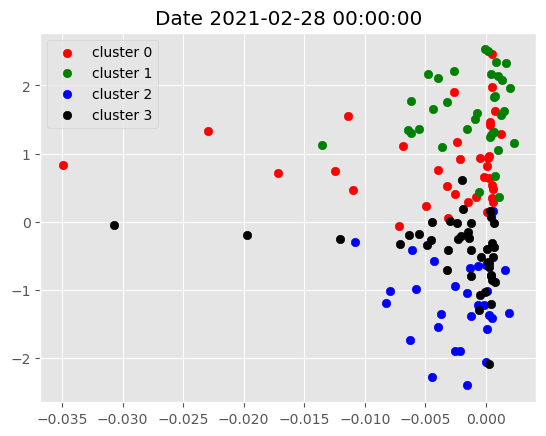

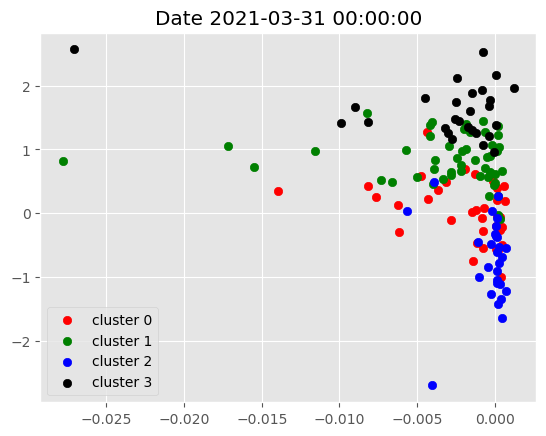

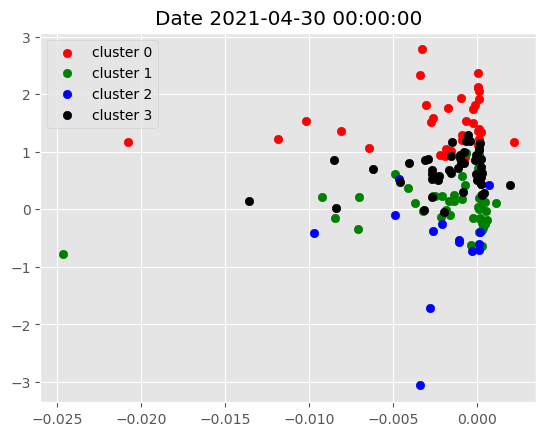

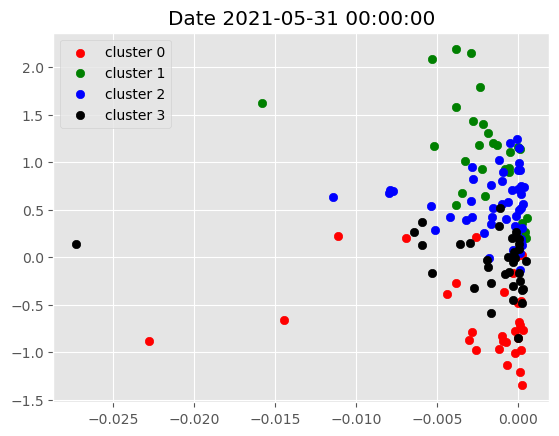

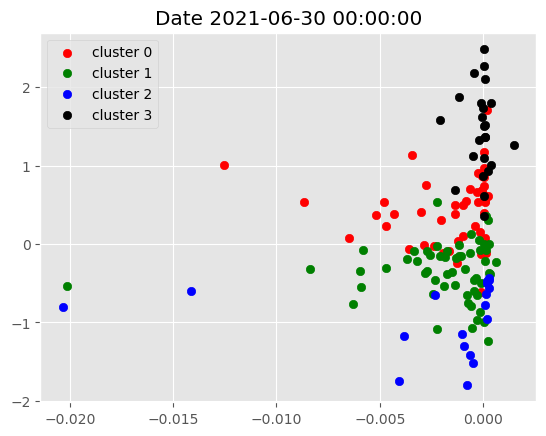

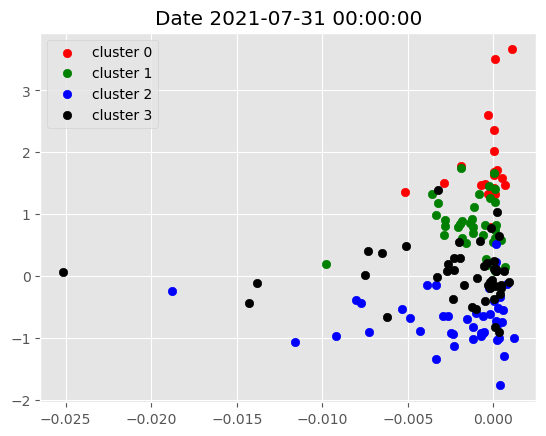

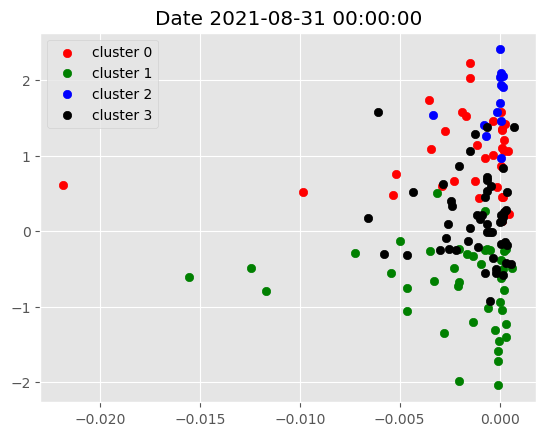

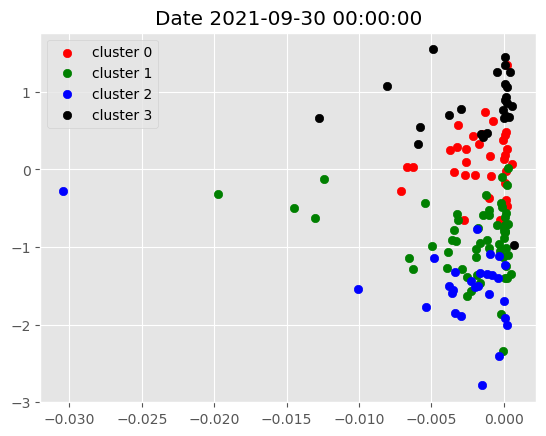

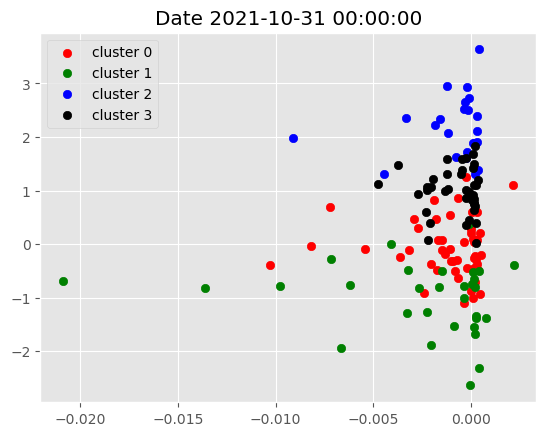

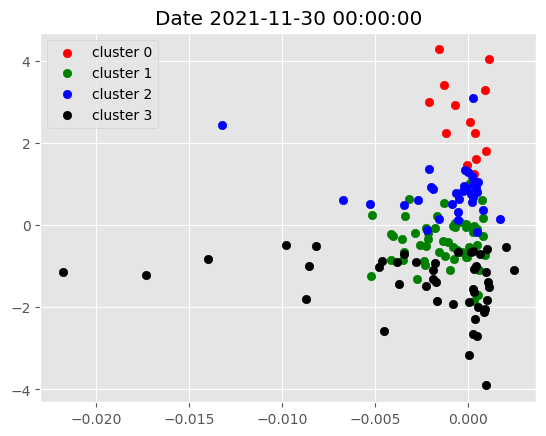

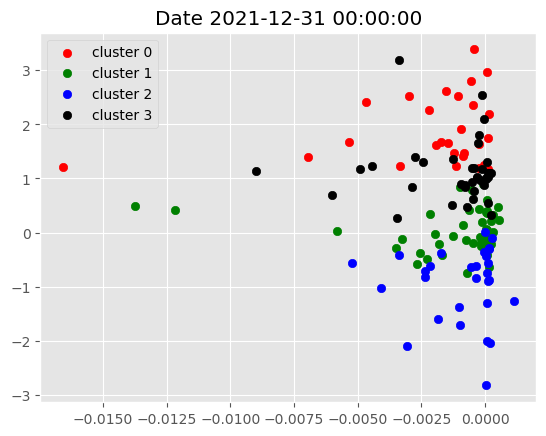

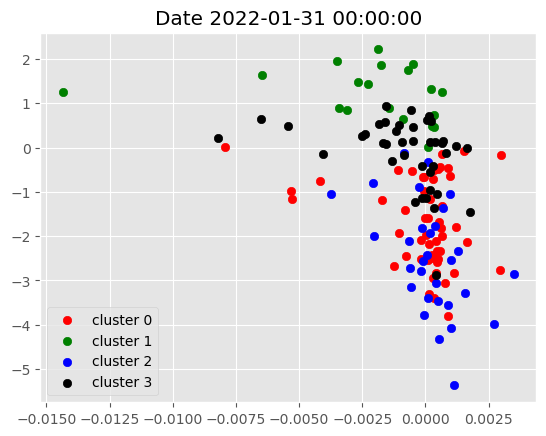

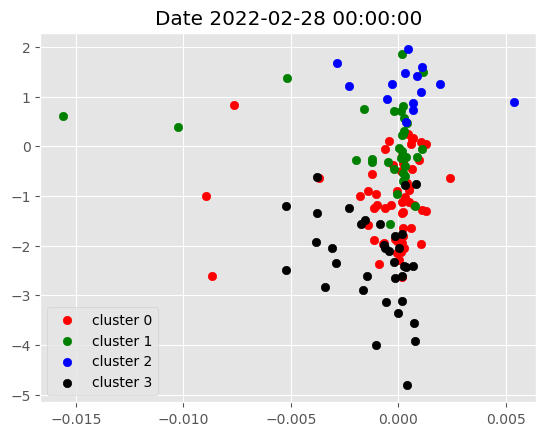

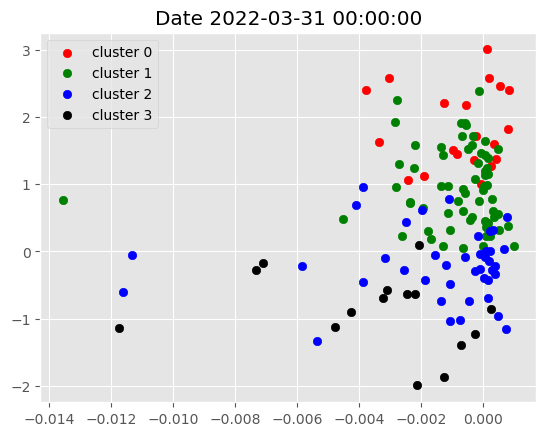

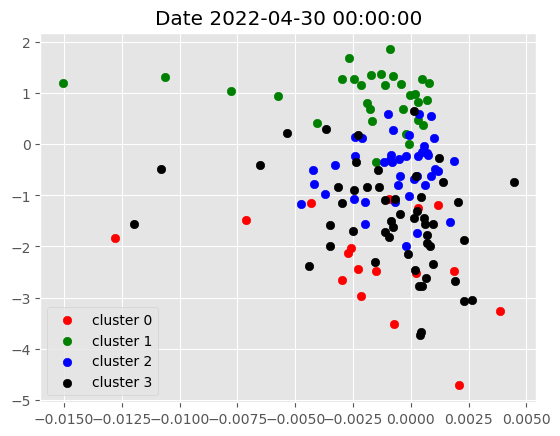

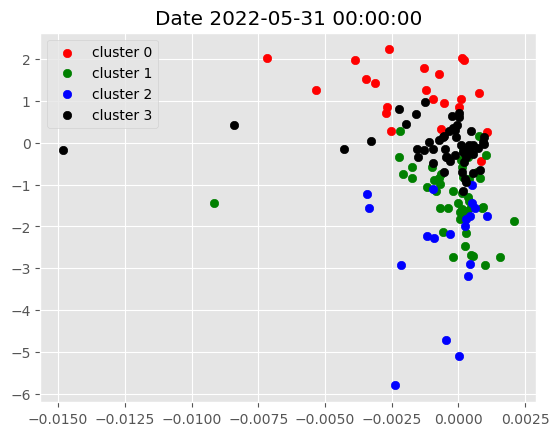

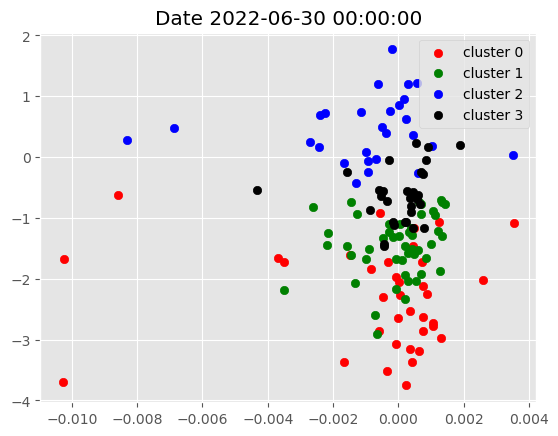

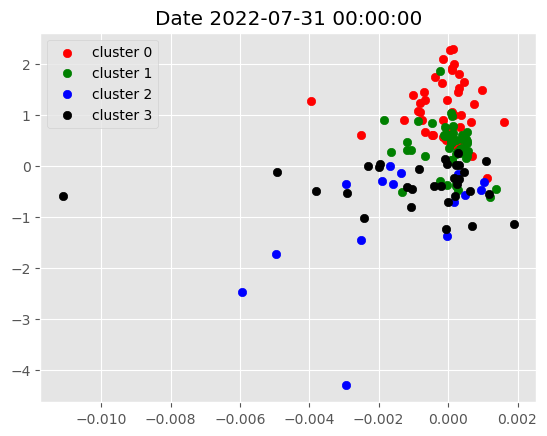

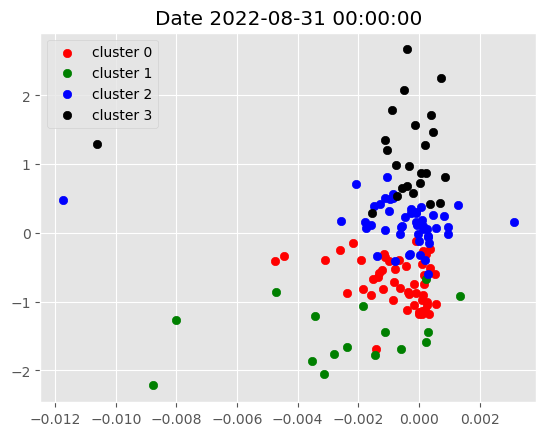

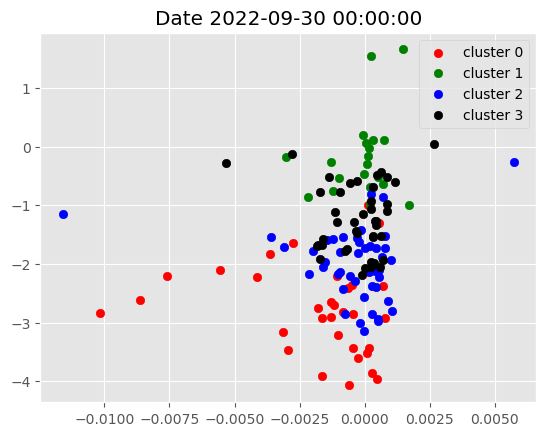

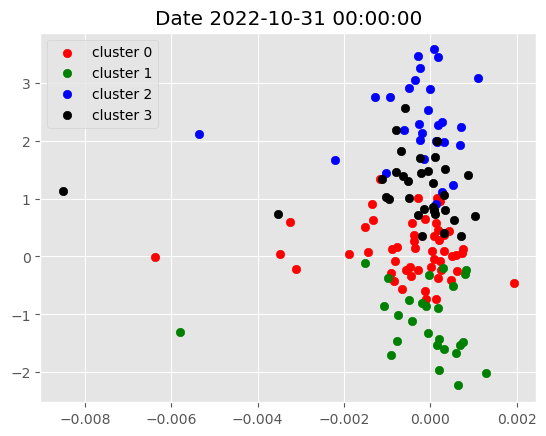

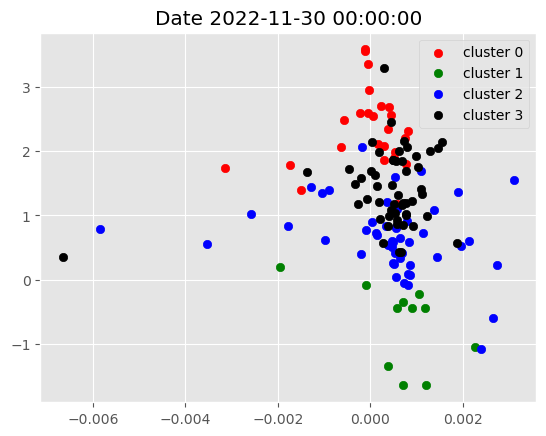

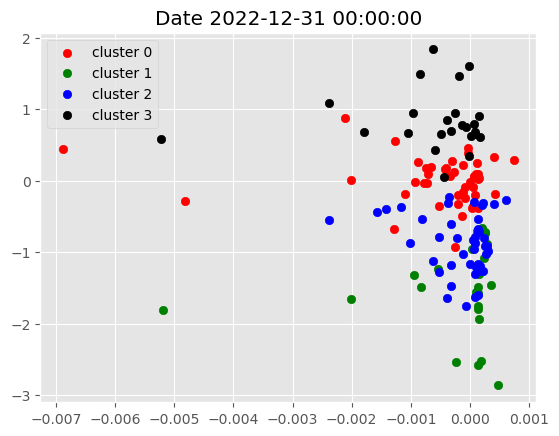

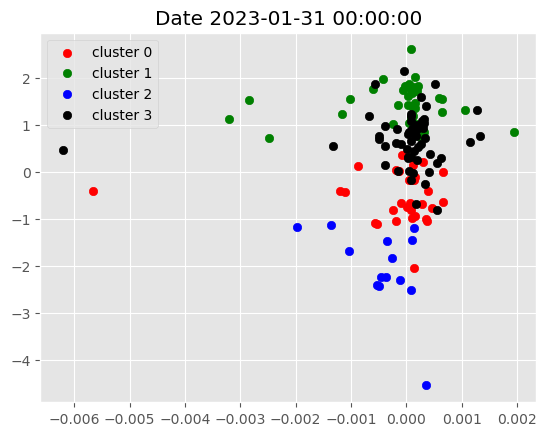

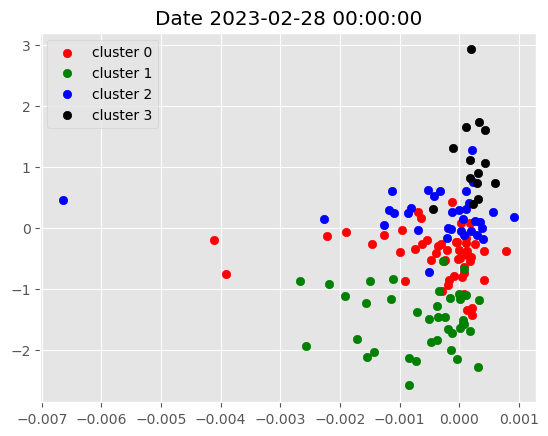

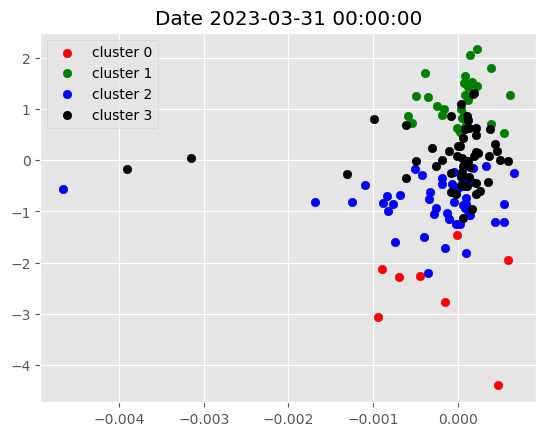

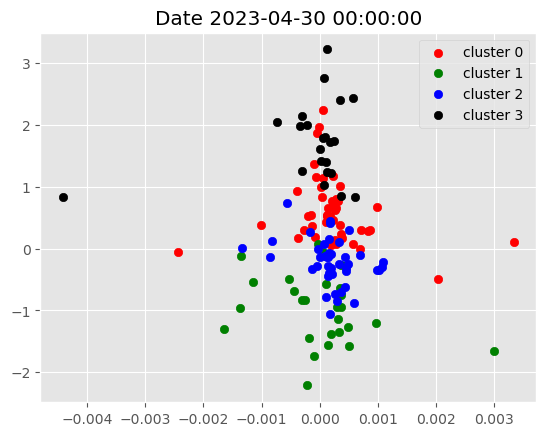

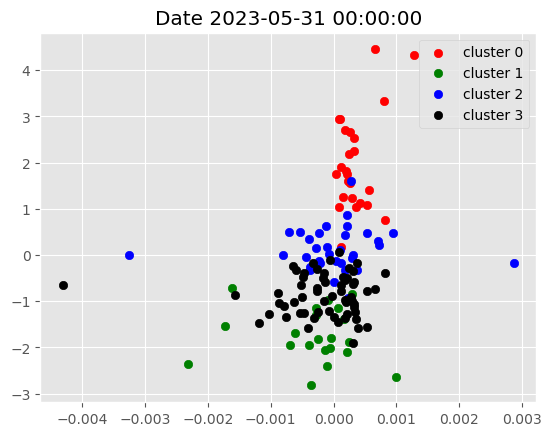

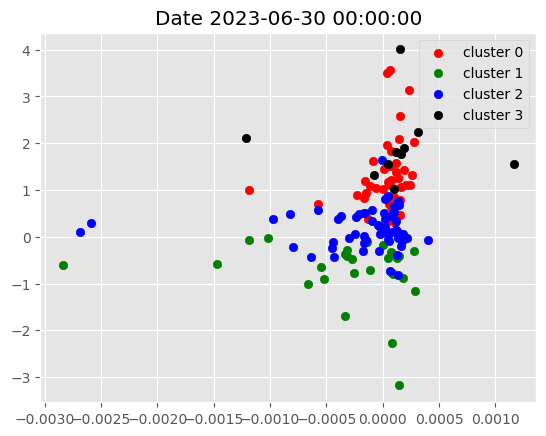

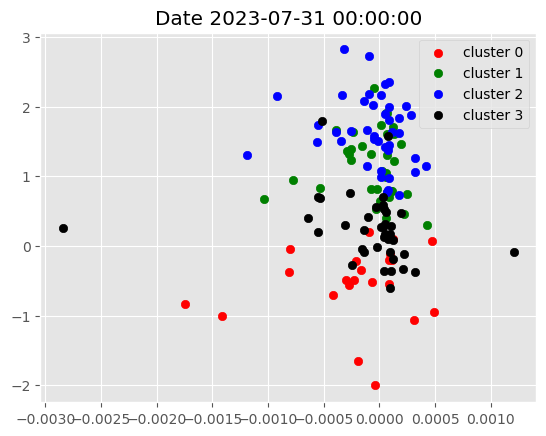

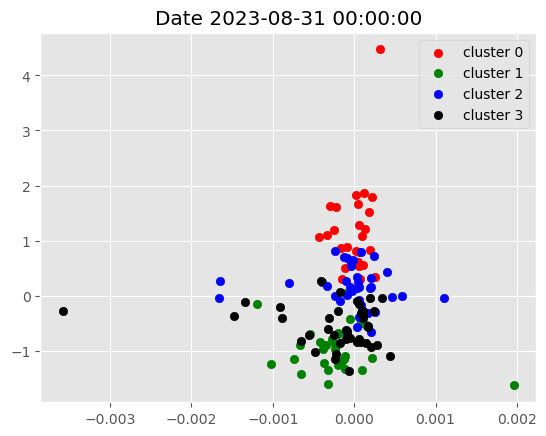

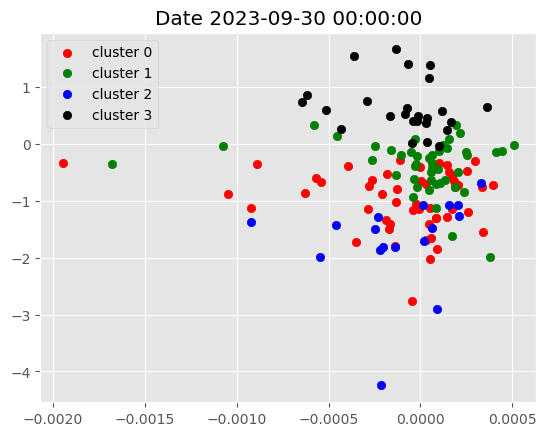

In [18]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

Apply pre-defined centroids.

In [19]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization
First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.

In [20]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2017-11-01': ['CMG',
  'CVS',
  'EXPE',
  'GE',
  'GILD',
  'MCK',
  'MRK',
  'PG',
  'PM',
  'REGN',
  'T',
  'WBA'],
 '2017-12-01': ['AIG',
  'AMAT',
  'BKNG',
  'CHTR',
  'CTSH',
  'EA',
  'EBAY',
  'EXPE',
  'FCX',
  'GE',
  'HAL',
  'MRK',
  'MU',
  'NFLX',
  'NXPI',
  'PM',
  'REGN',
  'SLB',
  'TSLA',
  'WDC'],
 '2018-01-01': ['AAPL',
  'AIG',
  'AMAT',
  'AMGN',
  'AVGO',
  'BKNG',
  'BMY',
  'CMG',
  'CRM',
  'CTSH',
  'EA',
  'EXPE',
  'GE',
  'GILD',
  'GM',
  'ISRG',
  'LLY',
  'MET',
  'MU',
  'NVDA',
  'ORCL',
  'REGN',
  'TSLA',
  'WDC'],
 '2018-02-01': ['AAPL',
  'AVGO',
  'F',
  'GE',
  'JNJ',
  'LLY',
  'LUV',
  'MCD',
  'MET',
  'PG',
  'REGN',
  'SBUX'],
 '2018-03-01': ['AVGO',
  'AXP',
  'C',
  'CAT',
  'COP',
  'CSX',
  'DAL',
  'DD',
  'DE',
  'DG',
  'DHR',
  'DIS',
  'ELV',
  'FCX',
  'FDX',
  'GILD',
  'GOOGL',
  'HON',
  'IBM',
  'KR',
  'LUV',
  'META',
  'MMM',
  'NEE',
  'ORLY',
  'PM',
  'QCOM',
  'SHW',
  'STZ',
  'T',
  'TMO',
  'UNH',
  'UNP',
  'USB

Define portfolio optimization function
We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [21]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

Download Fresh Daily Prices Data only for short listed stocks.

In [22]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  155 of 155 completed


Price       Adj Close                                                 \
Ticker            AAL        AAPL        ABBV        ABT         ACN   
Date                                                                   
2016-10-31  39.134323   26.212473   39.878788  34.112476  103.117409   
2016-11-01  38.363216   25.739206   40.357788  33.947311  103.028679   
2016-11-02  38.276459   25.762287   40.600876  33.643032  105.219841   
2016-11-03  38.054203   25.486147   39.957420  33.364861  103.747261   
2016-11-04  38.402084   25.256411   40.064659  33.982079  103.995644   
...               ...         ...         ...        ...         ...   
2023-09-25  12.910000  175.386337  148.897125  95.484749  311.950897   
2023-09-26  12.700000  171.282578  148.184692  94.270012  305.672302   
2023-09-27  12.610000  169.758591  147.433685  93.584259  309.382446   
2023-09-28  12.920000  170.017578  146.586426  96.121513  295.988739   
2023-09-29  12.810000  170.535538  143.515091  94.877373  302.227997   

Price                                                                  ...  \
Ticker            ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2016-10-31  107.510002   73.831535   72.279999  50.462044   26.606325  ...   
2016-11-01  106.870003   73.712814   70.099998  49.627831   26.441639  ...   
2016-11-02  105.889999   76.307877   68.680000  49.521496   26.158005  ...   
2016-11-03  107.169998   75.756615   67.610001  47.558640   25.865232  ...   
2016-11-04  106.199997   75.544594   69.440002  46.928886   25.819477  ...   
...                ...         ...         ...        ...         ...  ...   
2023-09-25  511.600006  235.844101  205.669998  61.170826  135.818924  ...   
2023-09-26  506.299988  233.112457  201.660004  60.314251  133.323090  ...   
2023-09-27  502.600006  238.408676  202.279999  60.068111  134.297577  ...   
2023-09-28  504.670013  239.076828  207.889999  60.333942  137.439713  ...   
2023-09-29  509.899994  236.394348  206.910004  59.664444  137.668427  ...   

Price         Volume                                                           \
Ticker             V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                            
2016-10-31  10024000  4969500  1928200  12459400   4662100  3363200  20115900   
2016-11-01  10881500  7816800  2458200  13229400   5130800  3821100  20020200   
2016-11-02   9170900  7317600  2580400  16488200   9783100  4216200  19566600   
2016-11-03   7563100  3855900  2371000  12605100   4586500  3192600  14982700   
2016-11-04   7588100  3729900  1902100  14410200   7023900  2705600  27391600   
...              ...      ...      ...       ...       ...      ...       ...   
2023-09-25   5921600  3241900   698100  17616900   6891000  2685900  10624000   
2023-09-26   6193200  4936800   633600  18841600   7570500  3571100  15219400   
2023-09-27   6006700  3644000   860600  22083500  10182900  2547800  11815500   
2023-09-28   4203900  3587300   578900  18772100   7291500  3282000  12454600   
2023-09-29   6044200  4302200   896800  19759400  25659100  2512000  13119100   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2016-10-31  19167000  1341600  16663800  
2016-11-01  26515800  3722300  13050600  
2016-11-02  22935900  2542400  11226100  
2016-11-03  20411700  9050400   8836500  
2016-11-04  21786300  3223800  13877100  
...              ...      ...       ...  
2023-09-25  10459500  1387800  11316000  
2023-09-26  14435700  1454000  11805400  
2023-09-27  15711000  2050000  23976200  
2023-09-28  11617200  1290400  16808100  
2023-09-29  18842400  1326800  18810700  

[1740 rows x 930 columns]

Calculate daily returns for each stock which could land up in our portfolio.

Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

Calculated each day portfolio return.

In [31]:
returns_dataframe =np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2017-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-06-01, Continuing with Equal-Weights
'return'


,Strategy Return
date,
2017-11-01,-0.001666
2017-11-02,-0.001021
2017-11-03,0.002206
2017-11-06,-0.008954
2017-11-07,0.005987
...,...
2023-09-25,0.001680
2023-09-26,-0.007720
2023-09-27,-0.001468


8. Visualize Portfolio returns and compare to SP500 returns.

In [37]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df


[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold_x,SPY Buy&Hold_y
2017-11-01,-0.001666,0.001322,0.001321
2017-11-02,-0.001021,0.000388,0.000388
2017-11-03,0.002206,0.003333,0.003333
2017-11-06,-0.008954,0.001547,0.001546
2017-11-07,0.005987,-0.000696,-0.000695
...,...,...,...
2023-09-25,0.001680,0.004196,0.004196
2023-09-26,-0.007720,-0.014800,-0.014800
2023-09-27,-0.001468,0.000399,0.000399
2023-09-28,0.007726,0.005781,0.005781


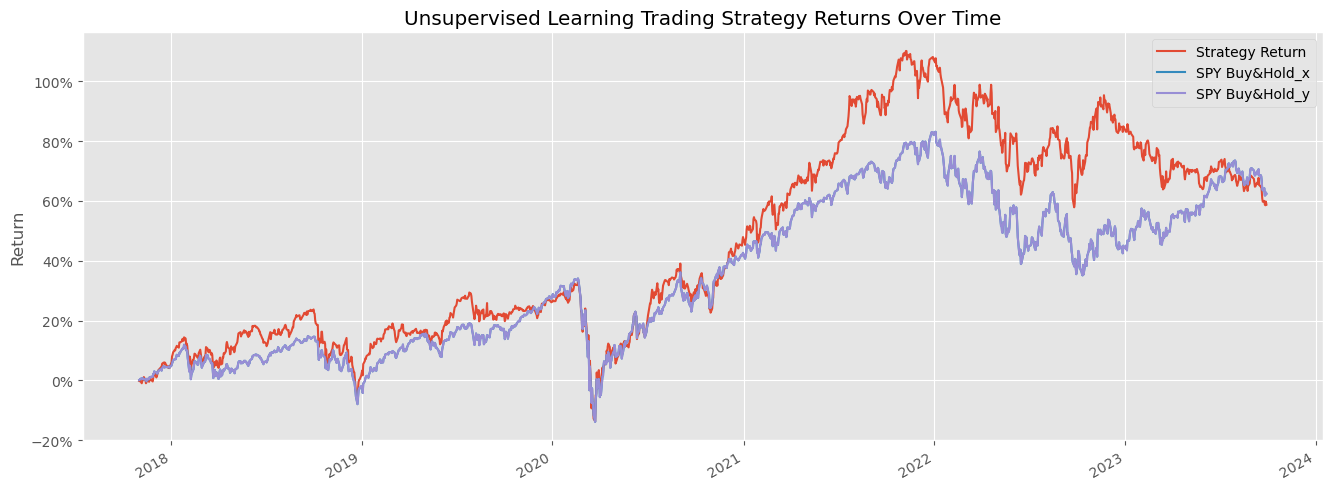

In [40]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()